## Import packages

#### This code has been modified from the source which can be found at https://github.com/fabiobdias/waom_notebook by author: Fabio Boeira Dias

In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
import matplotlib.path as mpath

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps


from shapely.ops import cascaded_union

# for gsw
import sys
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
import gsw

In [2]:
from xgcm import Grid
import warnings
warnings.filterwarnings('ignore')

In [88]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Set up the datasets

In [3]:
ds1  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0001.nc")
ds2  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0002.nc")
ds3  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0003.nc")
ds4  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0004.nc")
ds5  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0005.nc")
ds6  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0006.nc")
ds7  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0007.nc")
ds8  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0008.nc")
ds9  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0009.nc")
ds10 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0010.nc")
ds11 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0011.nc")
ds12 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0012.nc")

In [4]:
idx = 0
dens1 = np.zeros((4,31,560,630))
for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print(idx)
    
    temp = ds.variables["temp"]
    salt = ds.variables["salt"]

    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        #print("Vtransform=1")
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
        #print("Vtransform=2")
    ds.coords['z_rho'] = z_rho.transpose() # put z_rho into ds dataset

    # read grid file for lon/lat coordinates
    dg = xr.open_dataset("/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc")

    lat_rho = dg.variables["lat_rho"]
    lon_rho = dg.variables["lon_rho"]
    ds.coords['lat_rho']=lat_rho#.transpose() # put lat_rho into ds dataset
    ds.coords['lon_rho']=lon_rho#.transpose() # put lon_rho into ds dataset
    
    dens1 = dens1 + gsw.rho(salt,temp,0)-1000
    idx += 1

0
1
2
3
4
5
6
7
8
9
10
11


In [5]:
dens = dens1/12

In [6]:
def lonlat_labels(ax):
    # latitude labels
    ax.text(120,-80,'80$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(120,-70,'70$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    # longitude labels
    ax.text(0,-63.8,'0$^{\circ}$',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(-60,-55,'60$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(-120,-54.7,'120$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(180,-62,'180$^{\circ}$',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    return

proj = ccrs.SouthPolarStereo()

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)

bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')

In [7]:
# Handle interpolation from u and v grid to rho points:
# loop through the datasets and do the averaging
i = 0

for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print(i)

    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta + ds.zice
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta + ds.zice

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11


In [8]:
# call cartopy projectione
proj = ccrs.SouthPolarStereo()

# re-gridding
src = ccrs.SouthPolarStereo()
nx, ny = 630, 560

In [9]:
fig_path='/scratch/project_2000789/muramarg/floats_WAOM/july_questions/'

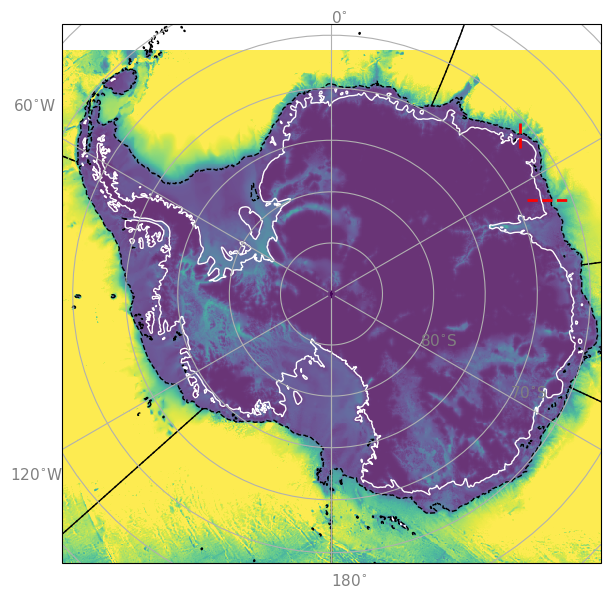

In [36]:
# 1 - slice section for salt/temp/z_rho
xi_ini =       [500, 0, 508]
xi_end =       [500, 0, 550]
eta_sec_ini =  [455, 0, 400]
eta_sec_end =  [486, 0, 400]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection=proj)
# cc = plt.pcolormesh(lon_rho.transpose(), lat_rho.transpose(), ds.h, transform=ccrs.PlateCarree(), vmin=0, vmax=3000)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds.h.isel(),transform=ccrs.PlateCarree(),
               alpha=0.8,vmax=4000)
ax.gridlines()
ax.coastlines(resolution='50m',color='white')
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)

# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_ini[ii]], lon_rho[eta_sec_end[ii],xi_end[ii]]],[lat_rho[eta_sec_ini[ii],xi_ini[ii]], lat_rho[eta_sec_end[ii],xi_end[ii]]],
         color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')

ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_ini[ii]], lon_rho[eta_sec_end[ii],xi_end[ii]]],[lat_rho[eta_sec_ini[ii],xi_ini[ii]], lat_rho[eta_sec_end[ii],xi_end[ii]]],
         color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')

lonlat_labels(ax)
ax.set_extent([-180, 180, -90, -64], ccrs.PlateCarree())

name_fig="locations.png"
plt.savefig(fig_path + name_fig)
plt.show()

### Make the figure

In [168]:
# Ross Sea
loc = 2

# 1 - slice section for salt/temp/z_rho
section_salt_rosE = np.empty((3,31,42)) # allocating
section_temp_rosE = np.empty((3,31,42))
section_rho_rosE = np.empty((3,31,42))
section_z_rosE = np.empty((3,31,42))
section_z_rosE_mask = np.empty((3,31,42))

for mm in np.arange(0,3):
    print(mm)
    
    # create the mean values first
    salt_mean = (ds1.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds2.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds3.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds4.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds5.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds6.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds7.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds8.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds9.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds10.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds11.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds12.salt.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values)/12
    temp_mean = (ds1.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds2.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds3.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds4.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds5.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds6.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds7.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds8.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds9.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds10.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds11.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds12.temp.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values)/12
    z_rho_mean = (ds1.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds2.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds3.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds4.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds5.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds6.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds7.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds8.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds9.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds10.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds11.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values+
                 ds12.z_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc], ocean_time=mm).values)/12  
    
    # now add them to the matrix
    section_salt_rosE[mm,:,:] = salt_mean
    section_temp_rosE[mm,:,:] = temp_mean
    section_z_rosE[mm,:,:] = z_rho_mean
    # 1.1 - mask land values in z_rho slice                                           
    section_z_rosE_mask[mm,:,:] = ma.array(section_z_rosE[mm,:,:],mask=np.isnan(section_z_rosE[mm,:,:]))
    section_rho_rosE[mm,:,:] = np.squeeze(dens[mm,:,eta_sec_ini[loc],xi_ini[loc]:xi_end[loc]])
       
# 2 - slide section for lon or lat
section_lat_rosE_tmp = dg.lat_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc])
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_rosE = np.ones((31,42))                                                
for ii in np.arange(0,31):
    section_lat_rosE[ii,:] = section_lat_rosE_tmp
section_lat_rosE_mask = ma.array(section_lat_rosE,mask=np.isnan(section_z_rosE[0,:,:]))

print(section_lat_rosE.shape, section_z_rosE.shape, section_salt_rosE.shape)

## season averages:
section_z_rosE_mask_JFM = np.squeeze(np.nanmean(section_z_rosE_mask[0:2,:,:], axis=0))
section_temp_rosE_JFM = np.squeeze(np.nanmean(section_temp_rosE[0:2,:,:], axis=0))
section_salt_rosE_JFM = np.squeeze(np.nanmean(section_salt_rosE[0:2,:,:], axis=0))
section_rho_rosE_JFM = np.squeeze(np.nanmean(section_rho_rosE[0:2,:,:], axis=0))

section_z_rosE_mask_ann = np.squeeze(np.nanmean(section_z_rosE_mask[:,:,:], axis=0))
section_temp_rosE_ann = np.squeeze(np.nanmean(section_temp_rosE[:,:,:], axis=0))
section_salt_rosE_ann = np.squeeze(np.nanmean(section_salt_rosE[:,:,:], axis=0))
section_rho_rosE_ann = np.squeeze(np.nanmean(section_rho_rosE[:,:,:], axis=0))

print(section_lat_rosE.shape, section_z_rosE_mask_JFM.shape, section_salt_rosE_JFM.shape)

0
1
2
(31, 42) (3, 31, 42) (3, 31, 42)
(31, 42) (31, 42) (31, 42)


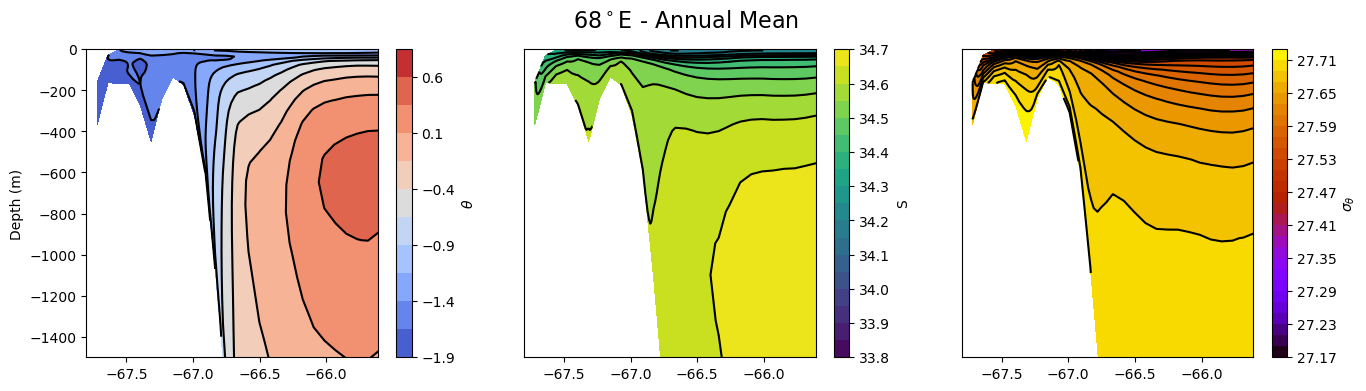

In [169]:
# Plot transects: Seasonal
levelsT = np.arange(-1.9,1,.25)
levelsS = np.arange(33.8,34.7,.05)
levelsR = np.arange(27.17,27.75,.02)

# Ross East
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,3,1)
ct = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_temp_rosE_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_temp_rosE_JFM, colors='k', levels=levelsT,linestyles="solid")
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='w', levels=levelsR)
plt.colorbar(ct,label="$θ$")
plt.xlim([-67.8,-65.61])
plt.ylim([-1500,0])
plt.suptitle('68$^\circ$E - Annual Mean',fontsize=16)
plt.ylabel('Depth (m)')

ax2 = fig.add_subplot(1,3,2)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_salt_rosE_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_salt_rosE_JFM, colors='k', levels=levelsS)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='w', levels=levelsR)
plt.colorbar(cs,label="S")
plt.xlim([-67.8,-65.61])
plt.ylim([-1500,0])

ax3 = fig.add_subplot(1,3,3)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='k', levels=levelsR)
plt.colorbar(cs,label="$\sigma_{θ}$")
plt.xlim([-67.8,-65.61])
plt.ylim([-1500,0])

ax2.set_yticks([])
ax3.set_yticks([])

name_fig="annual_68deg_transect.png"
plt.savefig(fig_path + name_fig)

plt.show()

In [170]:
# 50 degrees
loc = 0

# 1 - slice section for salt/temp/z_rho
section_salt_rosE = np.empty((3,31,31)) # allocating
section_temp_rosE = np.empty((3,31,31))
section_rho_rosE = np.empty((3,31,31))
section_z_rosE = np.empty((3,31,31))
section_z_rosE_mask = np.empty((3,31,31))

for mm in np.arange(0,3):
    print(mm)
    
    # create the mean values first
    salt_mean = (ds1.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds2.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds3.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds4.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds5.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds6.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds7.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds8.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds9.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds10.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds11.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds12.salt.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values)/12
    temp_mean = (ds1.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds2.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds3.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds4.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds5.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds6.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds7.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds8.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds9.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds10.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds11.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds12.temp.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values)/12
    z_rho_mean = (ds1.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds2.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds3.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds4.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds5.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds6.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds7.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds8.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds9.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds10.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds11.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values+
                 ds12.z_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm).values)/12  
    
    # now add them to the matrix
    section_salt_rosE[mm,:,:] = salt_mean
    section_temp_rosE[mm,:,:] = temp_mean
    section_z_rosE[mm,:,:] = z_rho_mean
    # 1.1 - mask land values in z_rho slice                                           
    section_z_rosE_mask[mm,:,:] = ma.array(section_z_rosE[mm,:,:],mask=np.isnan(section_z_rosE[mm,:,:]))
    section_rho_rosE[mm,:,:] = np.squeeze(dens[mm,:,eta_sec_ini[0]:eta_sec_end[0],xi_ini[0]])
       
# 2 - slide section for lon or lat
section_lat_rosE_tmp = dg.lat_rho.isel(xi_rho=xi_ini[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]))
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_rosE = np.ones((31,31))                                                
for ii in np.arange(0,31):
    section_lat_rosE[ii,:] = section_lat_rosE_tmp
section_lat_rosE_mask = ma.array(section_lat_rosE,mask=np.isnan(section_z_rosE[0,:,:]))

print(section_lat_rosE.shape, section_z_rosE.shape, section_salt_rosE.shape)

## season averages:
section_z_rosE_mask_JFM = np.squeeze(np.nanmean(section_z_rosE_mask[0:2,:,:], axis=0))
section_temp_rosE_JFM = np.squeeze(np.nanmean(section_temp_rosE[0:2,:,:], axis=0))
section_salt_rosE_JFM = np.squeeze(np.nanmean(section_salt_rosE[0:2,:,:], axis=0))
section_rho_rosE_JFM = np.squeeze(np.nanmean(section_rho_rosE[0:2,:,:], axis=0))

section_z_rosE_mask_ann = np.squeeze(np.nanmean(section_z_rosE_mask[:,:,:], axis=0))
section_temp_rosE_ann = np.squeeze(np.nanmean(section_temp_rosE[:,:,:], axis=0))
section_salt_rosE_ann = np.squeeze(np.nanmean(section_salt_rosE[:,:,:], axis=0))
section_rho_rosE_ann = np.squeeze(np.nanmean(section_rho_rosE[:,:,:], axis=0))

print(section_lat_rosE.shape, section_z_rosE_mask_JFM.shape, section_salt_rosE_JFM.shape)

0
1
2
(31, 31) (3, 31, 31) (3, 31, 31)
(31, 31) (31, 31) (31, 31)


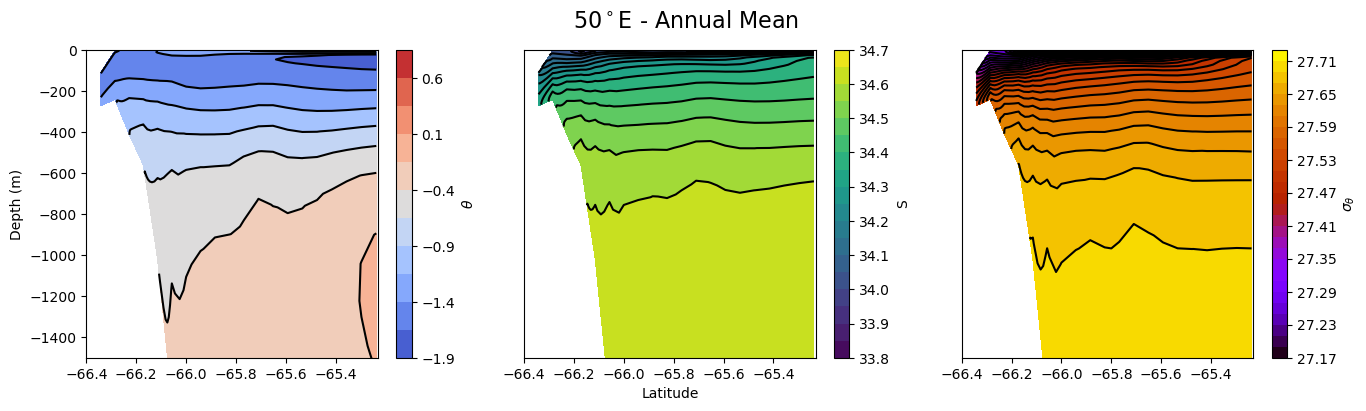

In [171]:
# Plot transects: Seasonal
levelsT = np.arange(-1.9,1,.25)
levelsS = np.arange(33.8,34.7,.05)
levelsR = np.arange(27.17,27.75,.02)

# Ross East
fig = plt.figure(figsize=(16,4))
fig.tight_layout()
ax1 = fig.add_subplot(1,3,1)
ct = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_temp_rosE_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_temp_rosE_JFM, colors='k', levels=levelsT,linestyles="solid")
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='w', levels=levelsR)
plt.colorbar(ct,label="$θ$")
plt.xlim([-66.4,-65.23])
plt.ylim([-1500,0])
plt.suptitle('50$^\circ$E - Annual Mean',fontsize=16)
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')
# plt.title()

ax2 = fig.add_subplot(1,3,2)
cs = ax2.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_salt_rosE_JFM, levels=levelsS, cmap=plt.cm.viridis)
ax2.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_salt_rosE_JFM, colors='k', levels=levelsS)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='w', levels=levelsR)
plt.colorbar(cs,label="S")
ax2.set_yticks([])
plt.xlim([-66.4,-65.23])
plt.ylim([-1500,0])
plt.xlabel('Latitude')
# plt.title("S")

ax3 = fig.add_subplot(1,3,3)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='k', levels=levelsR)
plt.colorbar(cs,label="$\sigma_{θ}$")
ax3.set_yticks([])
plt.xlim([-66.4,-65.23])
plt.ylim([-1500,0])
# plt.title()

name_fig="annual_50deg_transect.png"
plt.savefig(fig_path + name_fig)

plt.show()

In [174]:
from PIL import Image

im1 = Image.open(fig_path + "annual_68deg_transect.png")
im2 = Image.open(fig_path + "annual_50deg_transect.png")

In [176]:
# stack the images

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

get_concat_v(im1, im2).save(fig_path + 'concat_v.png')